# Atividade 4

## Equipe:

* Felipe Getúlio Laranjeira do Nascimento
* Lucas Pereira Reis

## Importação das bibliotecas

In [84]:
import pandas as pd
import numpy as np
import combination as comb
from math import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

## Realizando a leitura do *dataset*

In [85]:
df = pd.read_csv('seeds_dataset.txt', sep='\t', header=None)
df.columns = ["area","perimeter","compactness",
              "length_kernel","width_kernel","asymmetry_coefficient",
              "length_kernel_groove","variety"]
print(f'Tamanho do dataset: {len(df)}')

Tamanho do dataset: 210


# Analisando o *Dataset*

### 1. Histograma do atributo alvo

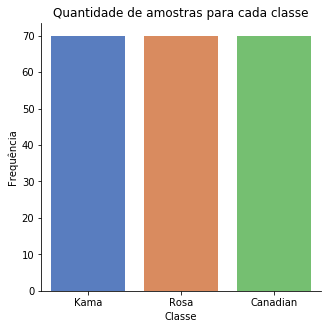

In [86]:
target_name = "variety"
g = sns.catplot(x=target_name, data=df, kind="count", palette="muted", height=4.5, aspect=1.0)
g.set_xticklabels(['Kama', 'Rosa', 'Canadian'])
g.set_axis_labels("Classe", "Frequência")
plt.title('Quantidade de amostras para cada classe')
plt.show()

Conforme pode ser visto no histograma, as classes do atributo alvo são balanceadas, pois o *dataset* possui um total de 210 amostras e cada classe possui 70 amostras.

### 2. Heatmap da correlação de Pearson dos atributos do dataset

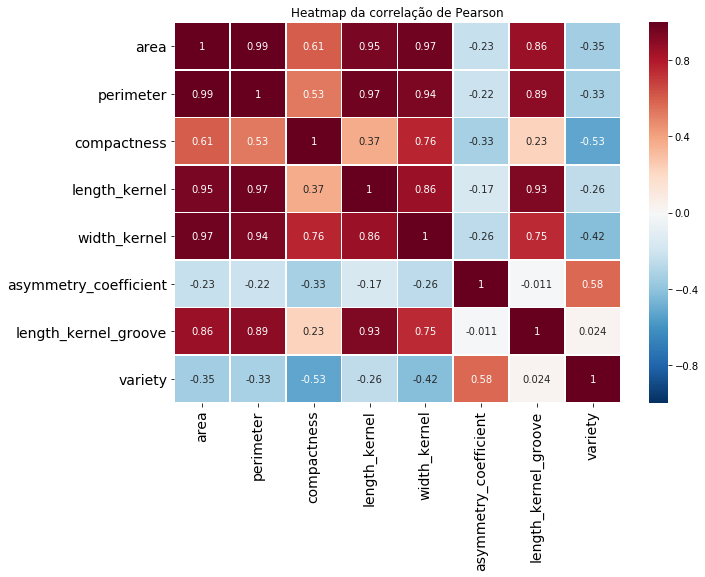

In [87]:
plt.figure(figsize = (10,7))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

corr = df.corr()

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,vmin=-1, vmax=1,linewidths=.5, cmap = "RdBu_r",annot=True)
plt.title('Heatmap da correlação de Pearson')
plt.show()

O *heatmap* acima exibe a correlação de Pearson entre todos os atributos do *dataset*, como pode ser visto o atributo `length_kernel_groove` possui uma correlação de aproximadamente igual a 0 com o atributo alvo `variety`. Assim, optou-se por remover o atributo do *dataset*.

In [88]:
df.drop(['length_kernel_groove'],axis=1,inplace=True)

# Pré-Processamento de Dados

Antes de começar a utilizar o `GridSearchCV`, precisa-se primeiramente preparar o *dataset* e alguns atributos para serem utilizados na busca.

In [89]:
target = df.variety
df.drop(['variety'],axis=1,inplace=True)

In [90]:
n_i, n_o = len(df.columns), 3

In [91]:
X_train, X_test, Y_train, Y_test = train_test_split(df,target,test_size=0.3)

In [92]:
def geometric_pyramid(alpha):
    return alpha*sqrt(n_i*n_o)

#### Observação:
Para um `alpha = 2` ou `alpha = 3` o algoritmo para gerar o subconjunto fica bastante pesado. Talvez seja necessário diminuir o valor de `n_i` retirando colunas desnecessárias ou utilizar PCA. Coloquei `alpha = 1` apenas para testar

In [93]:
alpha = [0.5,1]
n_h = [ceil(geometric_pyramid(a)) for a in alpha]
hidden_layer_sizes = []

for n in n_h:
    subsets = comb.partitions(n)
    hidden_layer_sizes = hidden_layer_sizes + subsets

# Paramêtros/Hiperparamêtros para a busca em grade

Na célula seguinte temos os paramêtros a serem passados para as redes neurais. Para o hiperparamêtro *solver*, optou-se por utilizar apenas o `lbfgs` pois o *dataset* desta atividade possui apenas 210 amostras, caracterizando-o como um *dataset* pequeno. Assim, o *solver* `lbfgs` será mais eficiente para o problema.

In [94]:
params = {
    'activation': ['identity', 'logistic','tanh','relu'],
    'hidden_layer_sizes': hidden_layer_sizes,
    'solver': ['lbfgs']
}

# Projetando Redes Neurais através da busca em grade

A acurácia foi selecionada como a métrica de desempenho a ser utilizada para as redes neurais do `GridSearchCV`, e o método de validação cruzada escolhido é o *k-fold* com *k* = 3.

In [95]:
gs = GridSearchCV(MLPClassifier(), params, cv=3, scoring='accuracy', return_train_score=1)

In [96]:
X,y = df,target

In [97]:
gs.fit(X,y);

In [98]:
pd.DataFrame(gs.cv_results_).drop('params', 1).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_hidden_layer_sizes,param_solver,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.049391,0.018130,0.000360,0.000015,identity,"(3,)",lbfgs,0.958333,0.927536,0.768116,0.885714,0.083227,1,0.905797,0.907801,1.000000,0.937866,0.043943
4,0.048853,0.000921,0.000397,0.000040,identity,"(5,)",lbfgs,0.958333,0.927536,0.768116,0.885714,0.083227,1,0.891304,0.907801,1.000000,0.933035,0.047828
11,0.051445,0.000329,0.000398,0.000042,identity,"(1, 4)",lbfgs,0.888889,0.942029,0.811594,0.880952,0.053178,3,0.855072,0.851064,0.936170,0.880769,0.039209
25,0.060185,0.008302,0.000387,0.000034,logistic,"(4, 1)",lbfgs,0.930556,0.927536,0.768116,0.876190,0.075613,4,0.920290,0.851064,0.971631,0.914328,0.049402
16,0.059598,0.000146,0.000372,0.000004,identity,"(1, 2, 2)",lbfgs,0.875000,0.942029,0.811594,0.876190,0.052875,4,0.884058,0.858156,0.936170,0.892795,0.032443


Acima temos o *DataFrame* das Redes Neurais projetadas com o `GridSearchCV` ordenadas pelo campo `rank_test_score`, ou seja, está sendo exibido as cinco melhores redes neurais criadas. É possível retornar apenas a melhor rede neural através do campo `best_estimator_`, conforme abaixo.

# Avaliando a melhor Rede Neural

In [99]:
best_model = gs.best_estimator_

In [100]:
Y_pred = best_model.predict(X_test)

In [101]:
accuracy_score(Y_test,Y_pred)

0.9206349206349206